In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [5]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 3.0

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure

params_ydf["max_num_nodes"] = None

params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "BINARY"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = None
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS


generate random data set with separated distribution

In [43]:
def generate_dataset(n_samples=1000, random_seed=42):  
    # Generate dataset
    n_samples = 1000  # Total number of samples
    class_1_size = n_samples // 2
    class_2_size = n_samples - class_1_size

    np.random.seed(random_seed)  # Set random seed for reproducibility
    # Class 1: Gaussian distribution with mean 10 and std 5 (values < 20)
    class_1 = np.random.normal(loc=10, scale=5, size=class_1_size)

    # Class 2: Gaussian distribution with mean 90 and std 5 (values > 80)
    class_2 = np.random.normal(loc=90, scale=5, size=class_2_size)

    # Combine the data
    X = np.concatenate([class_1, class_2]).reshape(-1, 1)
    y = np.array([0] * class_1_size + [1] * class_2_size)

    # Shuffle the dataset
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [51]:
def generate_dataset(n_samples=1000, num_dim=10, random_seed=42):  
    # Generate dataset
    class_1_size = n_samples // 2
    class_2_size = n_samples - class_1_size

    np.random.seed(random_seed)  # Set random seed for reproducibility
    # Class 1: Gaussian distribution with mean 10 and std 5 (values < 20)
    class_1 = np.random.normal(loc=10, scale=5, size=(class_1_size, num_dim))

    # Class 2: Gaussian distribution with mean 90 and std 5 (values > 80)
    class_2 = np.random.normal(loc=90, scale=5, size=(class_2_size, num_dim))

    # Combine the data
    X = np.vstack([class_1, class_2])
    y = np.array([0] * class_1_size + [1] * class_2_size)

    # Shuffle the dataset
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [ ]:
X, y = generate_dataset(n_samples=1000, num_dim=100, random_seed=42)

(1000, 10)

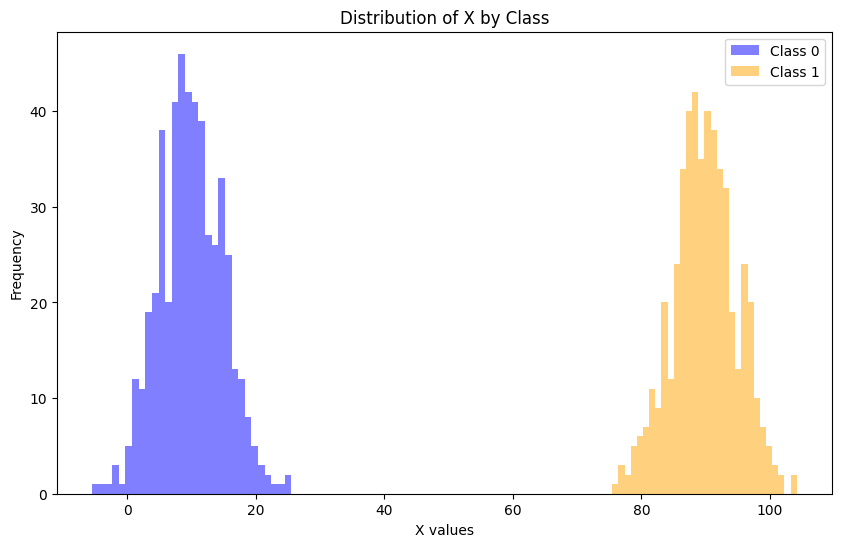

In [47]:
X, y = generate_dataset(n_samples=1000, random_seed=45)
plt.figure(figsize=(10, 6))
plt.hist(X[y == 0], bins=30, alpha=0.5, label='Class 0', color='blue')
plt.hist(X[y == 1], bins=30, alpha=0.5, label='Class 1', color='orange')
plt.xlabel('X values')
plt.ylabel('Frequency')
plt.title('Distribution of X by Class')
plt.legend()
plt.show()

In [69]:
def plot_distribution_with_threshold(X, y, threshold=None):
    """
    Plots the distribution of X by class and optionally adds a threshold line.

    Parameters:
    - X: numpy.ndarray, feature values
    - y: numpy.ndarray, class labels
    - threshold: float, optional, the threshold value to draw a vertical line
    """
    plt.figure(figsize=(10, 6))
    plt.hist(X[y == 0], bins=30, alpha=0.5, label='Class 0', color='blue')
    plt.hist(X[y == 1], bins=30, alpha=0.5, label='Class 1', color='orange')
    plt.xlabel('X values')
    plt.ylabel('Frequency')
    plt.title('Distribution of X by Class')
    plt.legend()
    if threshold is not None:
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
        plt.legend()
    plt.show()

Train model on 800 examples
Model trained in 0:00:00.005019


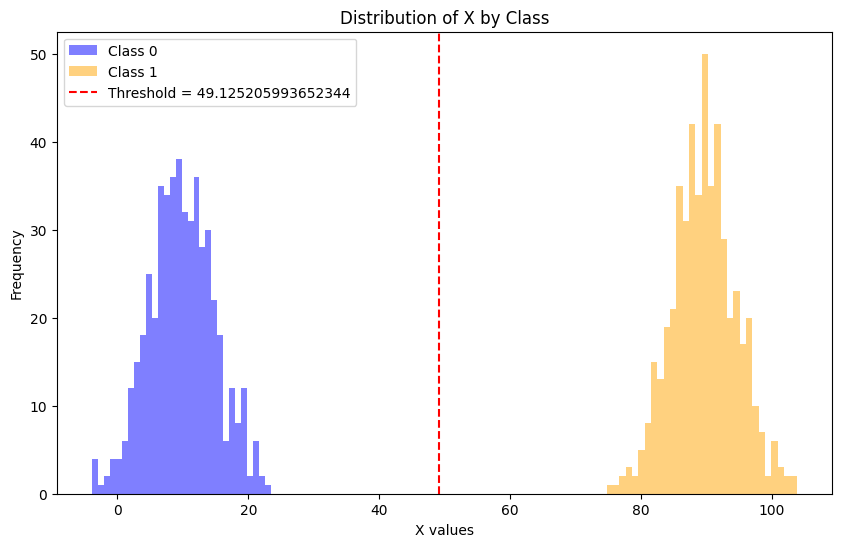

Train model on 800 examples
Model trained in 0:00:00.005010


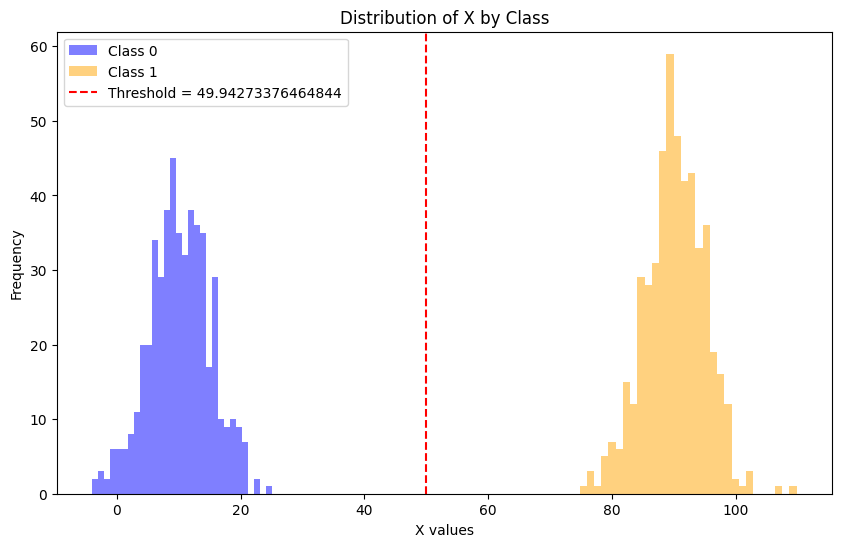

Train model on 800 examples
Model trained in 0:00:00.004000


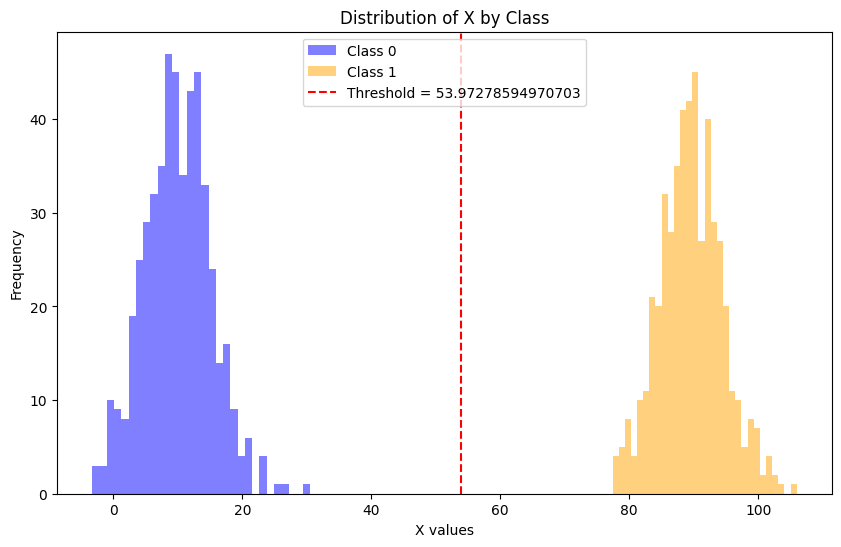

Train model on 800 examples
Model trained in 0:00:00.004645


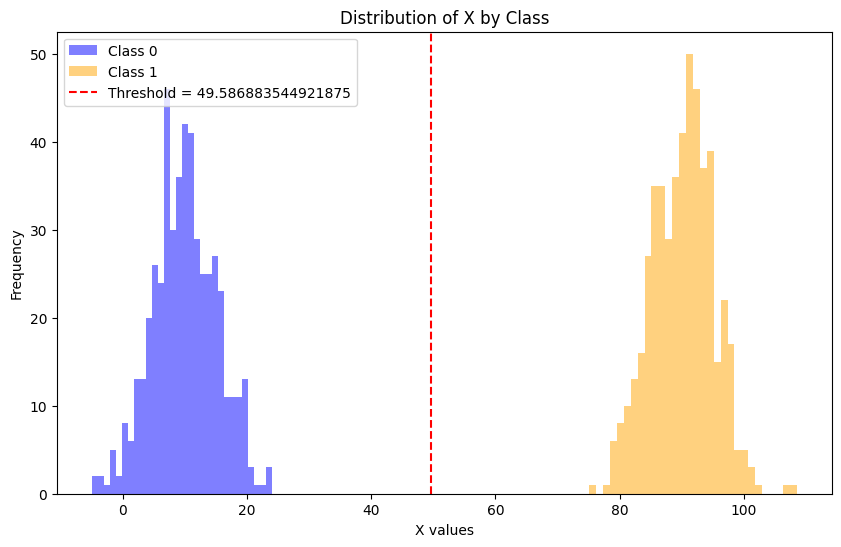

Train model on 800 examples
Model trained in 0:00:00.004027


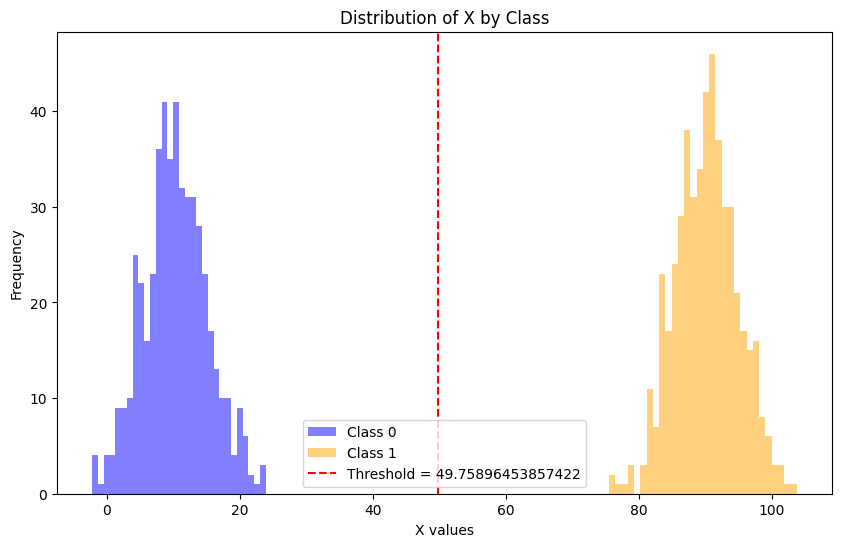

Train model on 800 examples
Model trained in 0:00:00.004011


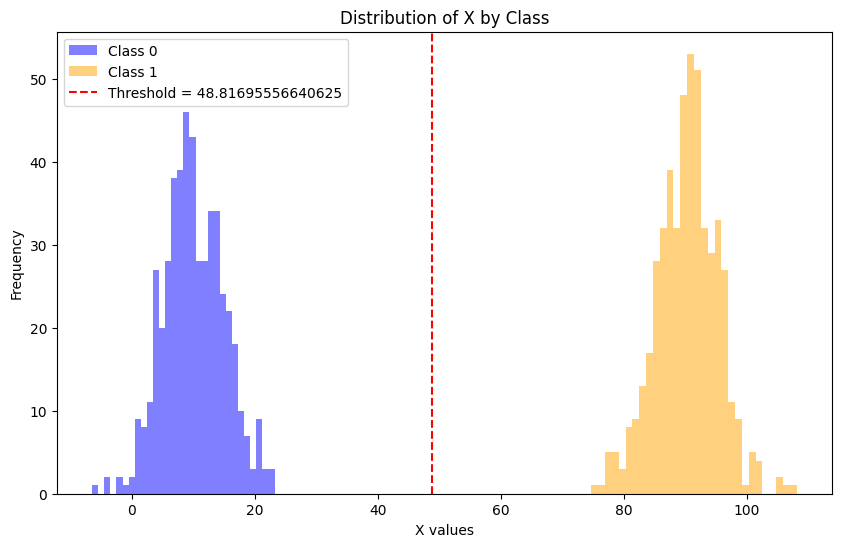

Train model on 800 examples
Model trained in 0:00:00.004001


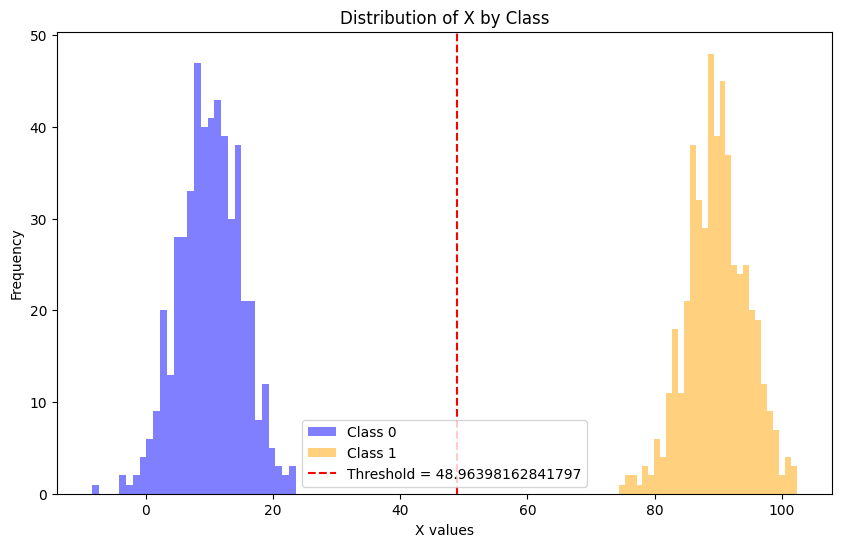

Train model on 800 examples
Model trained in 0:00:00.004521


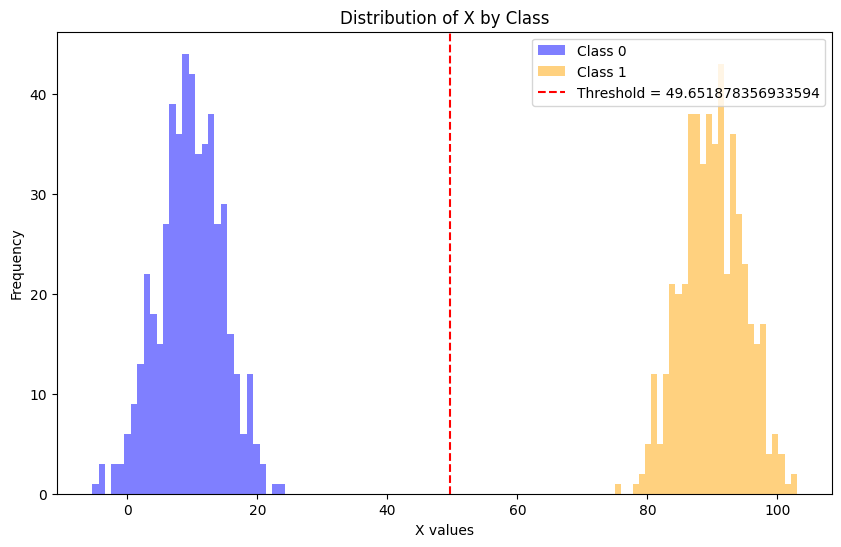

Train model on 800 examples
Model trained in 0:00:00.004694


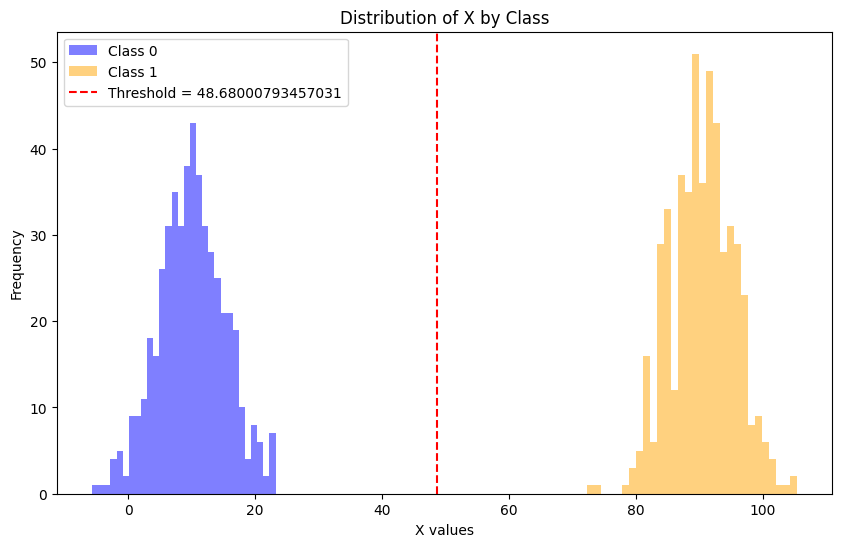

Train model on 800 examples
Model trained in 0:00:00.004025


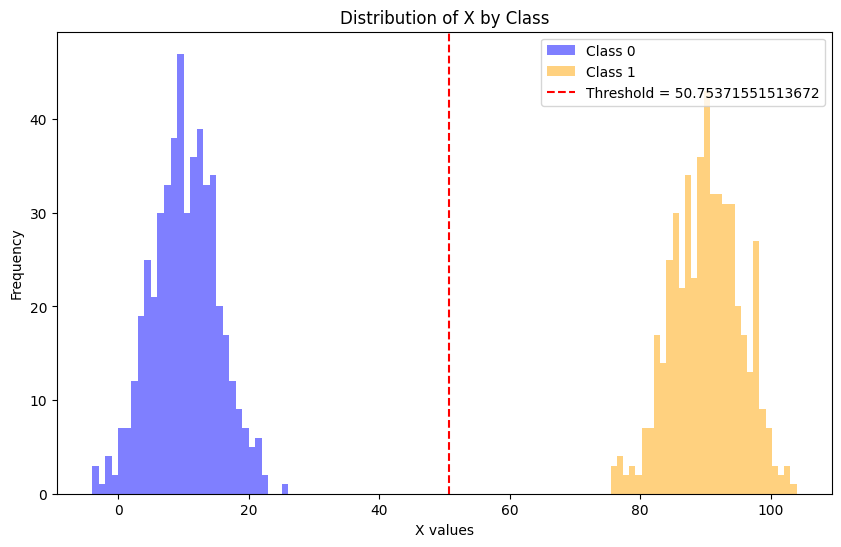

root threshold: [49.125205993652344, 49.94273376464844, 53.97278594970703, 49.586883544921875, 49.75896453857422, 48.81695556640625, 48.96398162841797, 49.651878356933594, 48.68000793457031, 50.75371551513672]
median of all data points: [50.75371230988909, 49.773716462549025, 50.194062380798016, 49.76075032402411, 50.08642166490418, 50.25764808942658, 50.166385139464275, 49.955716752833034, 49.85762486714414, 50.18678001135171]
mean of all data points: [49.773716462549025, 50.194062380798016, 49.76075032402411, 50.08642166490418, 50.25764808942658, 50.166385139464275, 49.955716752833034, 49.85762486714414, 50.18678001135171, 50.15786932055806]


In [71]:
num_dim = 1

n_rep = 10

threshold_values = []
median_values = []
mean_values = []

for i in range(n_rep):
    X, y = generate_dataset(n_samples=1000, num_dim=1, random_seed=i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)
    median_value = np.median(X)
    median_values.append(mean_value)
    mean_value = np.mean(X)
    mean_values.append(mean_value)

    # --- Train YDF ---
    params_ydf1 = params_ydf.copy()
    params_ydf1["random_seed"] = i
    learner = ydf.RandomForestLearner(**params_ydf1)

    ydf_model = learner.train(df_train)

    pred_ydf = ydf_model.predict(df_test)
    pred_ydf = (pred_ydf >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, pred_ydf)
    for i in range(1): #range(params_ydf1['num_trees']):
        threshold_value = ydf_model.get_tree(i).root.condition.threshold
        threshold_values.append(threshold_value)

    plot_distribution_with_threshold(X, y, threshold=threshold_value)


print("root threshold:", threshold_values)
print("median of all data points:", median_values)
print("mean of all data points:", mean_values)

